# Module 4 #
## Part 1
### Convert a 3D image into a spherical harmonic representation using CellOrganizer SPHARM-RPDM functionality

### Then create both a mesh reconstruction and an image reconstruction from the SPHARM-RPDM representation 

In [57]:
# Code Cell 1: import packages

from aicsimageio import AICSImage
import numpy as np
from pathlib import Path
from cellorganizer.tools import image2SPHARMparameterization, SPHARMparameterization2image, SPHARMparameterization2mesh
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

from sklearn.decomposition import PCA
import h5py

import matplotlib
import matplotlib.animation as manimation
import os

In [4]:
#Code Cell 2: read in selected image

directory = '/home/murphylab/cellorganizer/local/images/HeLa/3D/processed/'
cellImagesDirectoryPath = Path(directory + 'LAM_cell1_ch1_t1.tif')
img = AICSImage(cellImagesDirectoryPath)

# downsample factors
ds = [16, 16, 2]

data = img.data
data = np.squeeze(data) #get it down to a 3D image
data = np.transpose(data, (1, 2, 0)) #transpose to xyz
print(data.shape)

#downsample
data = data[::ds[0], ::ds[1], ::ds[2]]
#make sure data is shaped correctly
print(data.shape)

(1024, 1024, 18)
(64, 64, 9)


In [5]:
# Code Cell 3

params = image2SPHARMparameterization(data) #return back descriptors as dict
#params = image2SPHARMparameterization(data, options) #if user specific options are set

print(params['fvec'].shape)
print(type(params['fvec']))
print(params['fvec'].dtype)

CellOrganizer v2.10 (MATLAB RO2019a)
(841, 3)
<class 'numpy.ndarray'>
complex128


In [9]:
# Code Cell 4

mesh_mat = SPHARMparameterization2mesh(params)
# mesh_mat = SPHARMparameterization2mesh(params, options) #if user specific options are set

CellOrganizer v2.10 (MATLAB RO2019a)


### 3D visualization from the mesh

4002
8000


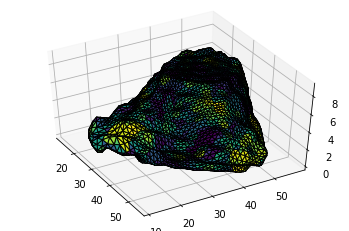

In [10]:
# Code Cell 5

# vertices
v = mesh_mat['Zvert']

# faces
f = mesh_mat['fs']-1

# assign a "color number" equal to the index of the face
C = np.array(list(range(len(mesh_mat['fs']))))
## an alternative is to assign each face a "color number" matching its average z coordinate
#C=np.empty(len(f))
#for itup in range(len(f)):
#    C[itup]=np.mean(v[f[itup]], axis=0)[2]
# normalize the color numbers to range 0-1
norm = plt.Normalize(C.min(), C.max())
# assign a color to each face
colors = plt.cm.viridis(norm(C))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="black")
ax.add_collection(pc)
vmins = np.amin(v, axis=0)
vmaxs = np.amax(v, axis=0)
ax.set_xlim(vmins[0], vmaxs[0])
ax.set_ylim(vmins[1], vmaxs[1])
ax.set_zlim(vmins[2], vmaxs[2])

elevation = 45
azimuth = 330
ax.view_init(elevation, azimuth)
plt.show()

### SPHARM PARAMS 2 IMAGE 

In [11]:
# Code Cell 6

img_mat = SPHARMparameterization2image(params)
# img_mat = SPHARMparameterization2image(params, options) #if user specific options are set

CellOrganizer v2.10 (MATLAB RO2019a)


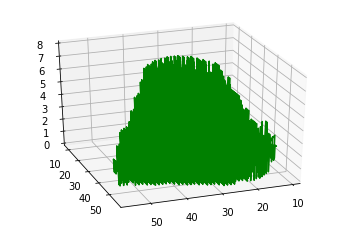

In [12]:
# Code Cell 7: make a projection of the 3D output image

abovezeroind = np.argwhere(img_mat)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.view_init(elev=30, azim=70)  
ax.plot3D(abovezeroind[:,0],abovezeroind[:,1],abovezeroind[:,2],'green')
plt.show()

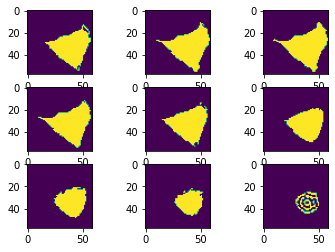

In [13]:
# Code Cell 8: now plot the individual xy slices of the 3D image

fig = plt.figure()
#islice = round(img_mat.shape[2]/2)
import math
panels = math.ceil(math.sqrt(img_mat.shape[2]))
for i in range(img_mat.shape[2]):
    plt.subplot(panels,panels,i+1)
    plt.imshow(img_mat[:,:,i])
plt.show()

## Part 2
### Create a movie by interpolating between them in the shape space.

In [73]:
# Code Cell 9

def vinterpolate(t, vector_a, vector_b):
# t is from interval <0, 1>
    return (1 - t) * vector_a + t * vector_b

def plotamesh(mesh_mat,fig):
    # vertices
    v = mesh_mat['Zvert']
    #print(len(v))
    # faces
    f = mesh_mat['fs']-1
    #print(len(f))

    # assign each face a "color number" matching its average z coordinate
    C=np.empty(len(f))
    for itup in range(len(f)):
        C[itup]=np.mean(v[f[itup]], axis=0)[2]
    # an alternative is to assign a "color number" equal to the index of the face
    #C = np.array(list(range(len(f))))
    # normalize the color numbers to range 0-1
    norm = plt.Normalize(C.min(), C.max())
    # assign a color to each face
    colors = plt.cm.viridis(norm(C))

    #fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="gray")
    ax.add_collection(pc)
    vmins = np.amin(v, axis=0)
    vmaxs = np.amax(v, axis=0)
    ax.set_xlim(vmins[0], vmaxs[0])
    ax.set_ylim(vmins[1], vmaxs[1])
    ax.set_zlim(vmins[2], vmaxs[2])

    elevation = 45
    azimuth = 330
    ax.view_init(elevation, azimuth)
    #plt.show()

In [98]:
# Code Cell 10

# downsample factors
ds = [8, 8, 8]


#read in selected images
directory = '/home/murphylab/cellorganizer/local/images/mitochondria/'
cellImagesDirectoryPath = Path(directory + 'mito_247.tif')
img_1 = AICSImage(cellImagesDirectoryPath)

data_1 = img_1.data
data_1 = np.squeeze(data_1) #get it down to a 3D image
data_1 = np.transpose(data_1, (1, 2, 0)) #transpose to xyz
print(data.shape)
#downsample
# data_1 = data_1[::ds[0], ::ds[1], ::ds[2]]

cellImagesDirectoryPath = Path(directory + 'mito_567.tif')
img_2 = AICSImage(cellImagesDirectoryPath)

data_2 = img_2.data
data_2 = np.squeeze(data_2) #get it down to a 3D image
data_2 = np.transpose(data_2, (1, 2, 0)) #transpose to xyz
print(data.shape)
#downsample
# data_2 = data_2[::ds[0], ::ds[1], ::ds[2]]

(64, 64, 9)
(64, 64, 9)


In [99]:
# Code Cell 11:  perform spharm transform on two images

params_1 = image2SPHARMparameterization(data_1)
params_2 = image2SPHARMparameterization(data_2)

CellOrganizer v2.10 (MATLAB RO2019a)
CellOrganizer v2.10 (MATLAB RO2019a)


### SPHARM PARAMS 2 MESH 

CellOrganizer v2.10 (MATLAB RO2019a)


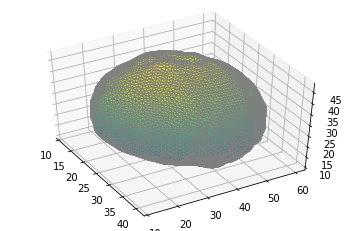

In [100]:
# Code Cell 12: convert descriptors to mesh and generate plot for the first object
mesh_mat1 = SPHARMparameterization2mesh(params_1)
#print(mesh_mat1)
plotamesh(mesh_mat1,plt.figure())

CellOrganizer v2.10 (MATLAB RO2019a)


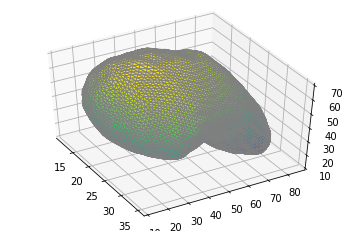

In [101]:
# Code Cell 13: convert descriptors to mesh and generate plot for the second object
mesh_mat2 = SPHARMparameterization2mesh(params_2)
plotamesh(mesh_mat2,plt.figure())

In [102]:
# Code Cell 14: flatten spharm descriptors and convert from complex to concatenated reals

fvec_1 = params_1['fvec']
fvec_2 = params_2['fvec']

fvec_1 = np.concatenate((fvec_1, np.zeros((1024 - fvec_1.shape[0], 3))), axis=0)
fvec_2 = np.concatenate((fvec_2, np.zeros((1024 - fvec_2.shape[0], 3))), axis=0)

fvec_1[0, :] = 0
fvec_2[0, :] = 0 

fvec_1_reshaped = np.reshape(fvec_1.T, (fvec_1.shape[0] * fvec_1.shape[1], ))
print(fvec_1_reshaped.shape)
fvec_1_reshaped = np.concatenate((fvec_1_reshaped.real, fvec_1_reshaped.imag), axis=0)
print(fvec_1_reshaped.shape)

fvec_2_reshaped = np.reshape(fvec_2.T, (fvec_2.shape[0] * fvec_2.shape[1], ))
print(fvec_2_reshaped.shape)
fvec_2_reshaped = np.concatenate((fvec_2_reshaped.real, fvec_2_reshaped.imag), axis=0)
print(fvec_2_reshaped.shape)

(3072,)
(6144,)
(3072,)
(6144,)


### First, we try to directly interpolate two object shapes

[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)


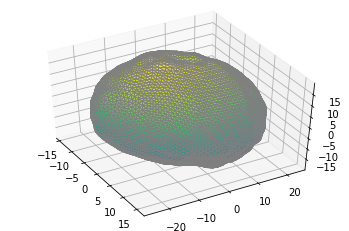

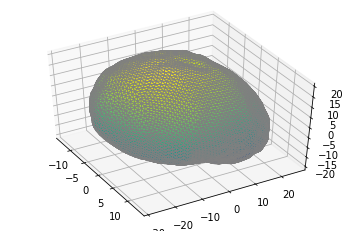

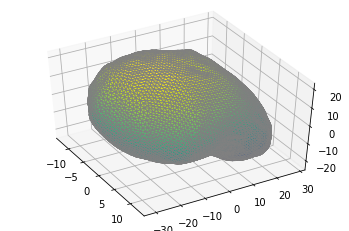

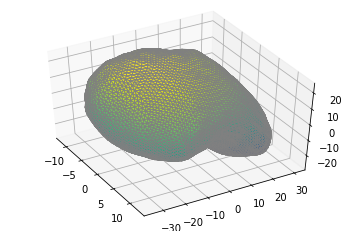

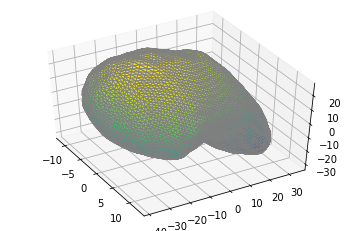

In [105]:
# Code Cell 15

# here, cps are constants here
cps = [2000, 3, 1024]
cps12 = 3 * 1024
print(cps)
max_deg = 31

startingshape = 0
endingshape = 1
nsteps = 5
for istep in range(0,nsteps):
    fulli = vinterpolate(istep/(nsteps-1), fvec_1_reshaped, fvec_2_reshaped)
    reconcplxi=fulli[0:cps12]+1j*fulli[cps12:cps12*2]
    reconshapedi=np.reshape(reconcplxi,(cps[1],cps[2]))
    paramsi = {}
    paramsi['deg'] = max_deg
    paramsi['fvec'] = np.transpose(reconshapedi[:,:],(1,0))
    print(paramsi['fvec'][0,])
    mesh_mati = SPHARMparameterization2mesh(paramsi)
    plotamesh(mesh_mati,plt.figure())

### now make a movie morphing first shape into second shape

[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.10 (MATLAB RO2019a)
[0.+0.j 0.+0.j 0.+0.j]
CellOrganizer v2.

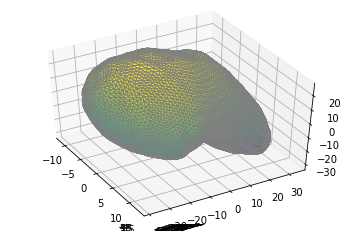

In [107]:
# Code Cell 16

folder_name = 'Module4'
topdir = "/home/murphylab/cellorganizer/local/results"
outputdir = topdir + "/" + folder_name
if not os.path.exists(topdir):
    os.makedirs(topdir)
os.chdir(topdir)
os.system("ls")
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
os.chdir(outputdir)
os.system("ls")

matplotlib.use("Agg")

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Example shape evolution', artist='CellOrganizer',
                comment='Created by Module 4')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure()

startingshape = 2
endingshape = 3
nsteps = 20
with writer.saving(fig, "ExampleOrganelleShapeEvolution.mp4", 100):
    for istep in range(0,nsteps):
        fulli = vinterpolate(istep/(nsteps-1), fvec_1_reshaped, fvec_2_reshaped)
        reconcplxi=fulli[0:cps12]+1j*fulli[cps12:cps12*2]
        reconshapedi=np.reshape(reconcplxi,(cps[1],cps[2]))
        paramsi = {}
        paramsi['deg'] = max_deg
        paramsi['fvec'] = np.transpose(reconshapedi[:,:],(1,0))
        print(paramsi['fvec'][0,])
        mesh_mati = SPHARMparameterization2mesh(paramsi)
        plotamesh(mesh_mati,fig)
        writer.grab_frame()

## Let's try another way: doing interpolation in PC-reduced space

### Read two example organelle shapes from a CellOrganizer model and create a movie by interpolating between them in the shape space.

In [108]:
# Code Cell 17

f = h5py.File('/home/murphylab/cellorganizer/local/models/mito_GT_model.mat', 'r')

# Read shape information from the model
model = f['model']
proteinModel = model['proteinModel']
spharm_obj_model = proteinModel['spharm_obj_model']
cellShapeModel = spharm_obj_model['cellShapeModel']
max_deg_dataset = cellShapeModel['max_deg']
print(type(max_deg_dataset))
print(max_deg_dataset)
max_deg = 31
# cell_params has full SPHARM descriptors for each object (#objects,)
cell_params=cellShapeModel['cell_params']
print(cell_params.shape)

<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "max_deg": shape (1, 1), type "<f8">
(2551, 3, 1024)


In [109]:
# Code Cell 18

params1 = {}
params2 = {}
params1['deg'] = max_deg
params2['deg'] = max_deg
# invert the order of the descriptors and convert from 'real','imag' pairs to complex
# (this is due to the difference in the way Matlab and python treat complex)
fv1 = np.transpose(cell_params[0,:,:],(1, 0))
params1['fvec']=np.vectorize(complex)(fv1['real'], fv1['imag'])
print(params1['fvec'].shape)
fv2 = np.transpose(cell_params[1,:,:],(1, 0))
params2['fvec']=np.vectorize(complex)(fv2['real'], fv2['imag'])
print(params2['fvec'].shape)
# print full descriptors for the first two objects
print(params1['fvec'][0,:])
print(params2['fvec'][0,:])

(1024, 3)
(1024, 3)
[137.71758697+2.67987597e-18j 129.63847094+2.22227868e-17j
  35.82448732+1.19865151e-17j]
[12.21907341-8.78673658e-19j 12.36426735-1.31801049e-18j
 16.66105342+4.55027430e-19j]


### SPHARM PARAMS 2 MESH

CellOrganizer v2.10 (MATLAB RO2019a)


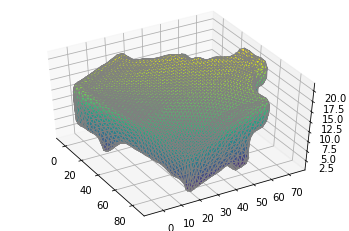

In [110]:
# Code Cell 19: convert descriptors to mesh and generate plot for the first object
mesh_mat1 = SPHARMparameterization2mesh(params1)
#print(mesh_mat1)
plotamesh(mesh_mat1,plt.figure())

CellOrganizer v2.10 (MATLAB RO2019a)


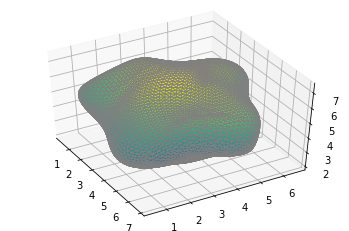

In [111]:
# Code Cell 20: convert descriptors to mesh and generate plot for the second object
mesh_mat2 = SPHARMparameterization2mesh(params2)
plotamesh(mesh_mat2,plt.figure())

### Flatten descriptors and reduce dimensionality of descriptors using PCA
### Note constant for number of PCs to keep (increasing provides better reconstruction)

In [112]:
# Code Cell 21

# flatten spharm descriptors and convert from complex to concatenated reals
cps=cell_params.shape
print(cps)
flatparams=np.reshape(cell_params,(cps[0],cps[1]*cps[2]))
print(flatparams.shape)
print(flatparams[0,0:3])
flatreal=np.concatenate((flatparams['real'],flatparams['imag']), axis=1)
print(flatreal.shape)
print(flatreal.dtype)
# make the PCA model and convert flattened descriptors to compressed and back for testing
# >>> set the number of PCs to keep here
pca = PCA(n_components=100)
reducedflat=pca.fit_transform(flatreal)
print(reducedflat.shape)
# convert back to flattened descriptors
reconflat=pca.inverse_transform(reducedflat)
print(reconflat.shape)
print(reconflat[0,0],reconflat[0,3072])
print(flatreal[0,0],flatreal[0,3072])
print(reconflat[0,0],reconflat[0,3072])
# now reverse previous steps - one way to convert back to complex
reconsplit=np.reshape(reconflat,(cps[0],-1,2))
reconcplx=np.vectorize(complex)(reconsplit[:,:,0], reconsplit[:,:,1])
print(reconcplx.shape)
print(reconcplx.dtype)
print(reconcplx[0,0])
# another way
cps12=cps[1]*cps[2]
reconr=reconflat[:,0:cps12]
reconi=reconflat[:,cps12:cps12*2]
print(reconr.shape, reconi.shape)
print(reconr[0,0:3],reconi[0,0:3])
reconcplx=reconr+1j*reconi
print(reconcplx.shape)
print(reconcplx.dtype)
print(reconcplx[0,0])
# convert back to 3,
reconshaped=np.reshape(reconcplx,(cps[0],cps[1],cps[2]))
print(reconshaped.shape)
print(reconshaped.dtype)
print(cell_params[0,:,0])
print(reconshaped[0,:,0])
print(params1['fvec'][0,:])

(2551, 3, 1024)
(2551, 3072)
[(137.71758697,  2.67987597e-18) (  2.06817627, -3.53227995e+00)
 ( 88.32004543, -9.19604752e-17)]
(2551, 6144)
float64
(2551, 100)
(2551, 6144)
137.71700306941 -1.3263647792821252e-14
137.71758696598525 2.679875969169513e-18
137.71700306941 -1.3263647792821252e-14
(2551, 3072)
complex128
(137.71700306941+2.06327387015362j)
(2551, 3072) (2551, 3072)
[137.71700307   2.06327387  88.31982995] [-1.32636478e-14 -3.54972936e+00  2.49009410e-15]
(2551, 3072)
complex128
(137.71700306941-1.3263647792821252e-14j)
(2551, 3, 1024)
complex128
[(137.71758697, 2.67987597e-18) (129.63847094, 2.22227868e-17)
 ( 35.82448732, 1.19865151e-17)]
[137.71700307-1.32636478e-14j 129.63839423+7.70727719e-15j
  35.82232581+1.86466720e-14j]
[137.71758697+2.67987597e-18j 129.63847094+2.22227868e-17j
  35.82448732+1.19865151e-17j]


### plot the mesh for the descriptors reconstructed from PCs

[137.71700307-1.32636478e-14j 129.63839423+7.70727719e-15j
  35.82232581+1.86466720e-14j]
CellOrganizer v2.10 (MATLAB RO2019a)


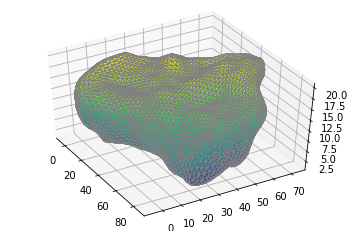

In [113]:
# Code Cell 22

params3 = {}
params3['deg'] = max_deg
params3['fvec'] = np.transpose(reconshaped[0,:,:],(1,0))
mesh_mat3 = SPHARMparameterization2mesh(params3)
plotamesh(mesh_mat3,plt.figure())

[12.2193286 +3.52497229e-15j 12.36427121-1.14708648e-14j
 16.66047493+3.63046725e-16j]
CellOrganizer v2.10 (MATLAB RO2019a)


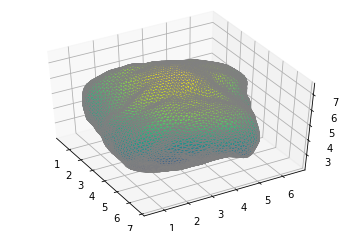

In [114]:
# Code Cell 23

params4 = {}
params4['deg'] = max_deg
params4['fvec'] = np.transpose(reconshaped[1,:,:],(1,0))
mesh_mat4 = SPHARMparameterization2mesh(params4)
plotamesh(mesh_mat4,plt.figure())

### now illustrate how to morph one shape into another (just show a few steps)
### this morphing process is also referred to as shape evolution
### use the PC representation for interpolation

[137.71700307-1.32636478e-14j 129.63839423+7.70727719e-15j
  35.82232581+1.86466720e-14j]
CellOrganizer v2.10 (MATLAB RO2019a)
[106.34258445-9.06649277e-15j 100.31986347+2.91274171e-15j
  31.03186309+1.40757656e-14j]
CellOrganizer v2.10 (MATLAB RO2019a)
[74.96816583-4.86933775e-15j 71.00133272-1.88179378e-15j
 26.24140037+9.50485934e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[43.59374721-6.72182731e-16j 41.68280196-6.67632927e-15j
 21.45093765+4.93395303e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[12.2193286 +3.52497229e-15j 12.36427121-1.14708648e-14j
 16.66047493+3.63046725e-16j]
CellOrganizer v2.10 (MATLAB RO2019a)


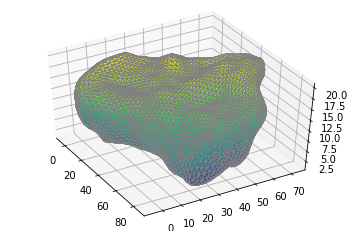

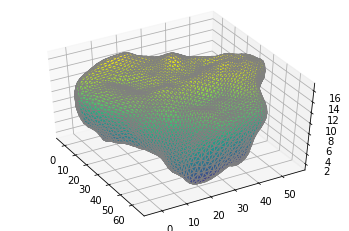

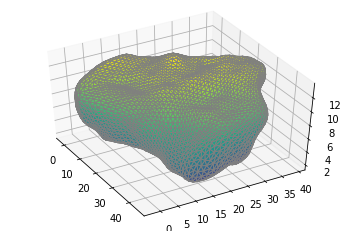

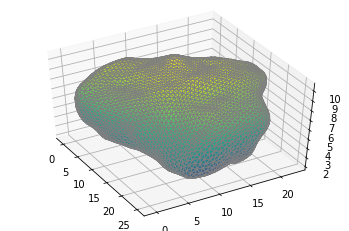

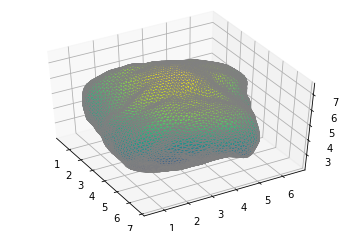

In [115]:
# Code Cell 24

startingshape = 0
endingshape = 1
nsteps = 5
for istep in range(0,nsteps):
    reducedi = vinterpolate(istep/(nsteps-1), reducedflat[startingshape,:], reducedflat[endingshape,:])
    fulli = pca.inverse_transform(reducedi)
    reconcplxi=fulli[0:cps12]+1j*fulli[cps12:cps12*2]
    reconshapedi=np.reshape(reconcplxi,(cps[1],cps[2]))
    paramsi = {}
    paramsi['deg'] = max_deg
    paramsi['fvec'] = np.transpose(reconshapedi[:,:],(1,0))
    mesh_mati = SPHARMparameterization2mesh(paramsi)
    plotamesh(mesh_mati,plt.figure())

### now make a movie morphing first shape into second shape

[23.1245515 +3.76060257e-15j 24.50540624-5.53929306e-14j
 17.06154758+3.93982322e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[19.36163666+1.62057430e-15j 21.75619512-3.76583837e-14j
 15.93752141+3.07195060e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[15.59872182-5.19453969e-16j 19.006984  -1.99238369e-14j
 14.81349524+2.20407799e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[11.83580698-2.65948224e-15j 16.25777288-2.18929005e-15j
 13.68946907+1.33620537e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[ 8.07289214-4.79951051e-15j 13.50856175+1.55452568e-14j
 12.5654429 +4.68332753e-16j]
CellOrganizer v2.10 (MATLAB RO2019a)


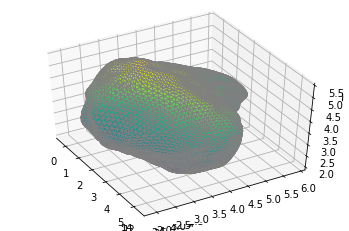

In [116]:
# Code Cell 25

folder_name = 'Module8B'
topdir = "/home/murphylab/cellorganizer/local/results"
outputdir = topdir + "/" + folder_name
if not os.path.exists(topdir):
    os.makedirs(topdir)
os.chdir(topdir)
os.system("ls")
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
os.chdir(outputdir)
os.system("ls")

matplotlib.use("Agg")

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Example shape evolution', artist='CellOrganizer',
                comment='Created by Module 8B')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure()

startingshape = 2
endingshape = 3
nsteps = 5
with writer.saving(fig, "ExampleOrganelleShapeEvolution.mp4", 100):
    for istep in range(0,nsteps):
        reducedi = vinterpolate(istep/(nsteps-1), reducedflat[startingshape,:], reducedflat[endingshape,:])
        fulli = pca.inverse_transform(reducedi)
        reconcplxi=fulli[0:cps12]+1j*fulli[cps12:cps12*2]
        reconshapedi=np.reshape(reconcplxi,(cps[1],cps[2]))
        paramsi = {}
        paramsi['deg'] = max_deg
        paramsi['fvec'] = np.transpose(reconshapedi[:,:],(1,0))
        print(paramsi['fvec'][0,])
        mesh_mati = SPHARMparameterization2mesh(paramsi)
        plotamesh(mesh_mati,fig)
        writer.grab_frame()